# Poisoning Attack Examples

This notebook demonstrates three poisoning attacks in a federated learning setting, showcasing the potential vulnerabilities of collaborative training. We'll explore one untargeted and two targeted attacks:

* **Untargeted Attack:** The adversary aims to degrade the overall accuracy of the global model.
* **Label Flipping Attack:** The adversary targets a specific label (in this case, label 0), attempting to reduce the model's ability to classify it.
* **Backdoor Attack:** The attacker introduces a backdoor, enabling high accuracy for specific inputs with a hidden trigger, while maintaining overall model performance.

To illustrate these attacks, we'll use the Wine dataset and introduce three participants: Alice, Bob, and Charlie.  Charlie has Dissociative Identity Disorder (DID) and occasionally switches to the malicious personality "Mallory", who executes the attacks. This setup allows us to compare the global model's performance when trained with benign and malicious participants.

First, let's load the wine dataset and prepare the data partitions for Alice, Bob, and Charlie.

In [18]:
#Imports
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

In [19]:
RANDOM_SEED = 34 

# Load the wine dataset into a DataFrame
wine = load_wine(as_frame=True)
df = wine.frame

# Split the dataset in training and test set
df_train, df_test = train_test_split(df, test_size=0.3, stratify=df['target'], random_state=RANDOM_SEED)

# Create DataFrames for Alice, Bob, and Charlie (equally distributed)
df_a, df_temp = train_test_split(df_train, test_size=2/3, stratify=df_train['target'], random_state=RANDOM_SEED)
df_b, df_c = train_test_split(df_temp, test_size=0.5, stratify=df_temp['target'], random_state=RANDOM_SEED)

# Display the data distribution for each participant
for i, df_participant in enumerate([df_a, df_b, df_c]):
    print(f"\nData distribution for Participant {chr(ord('A') + i)}:")
    value_counts = df_participant['target'].value_counts()
    total_count = len(df_participant)
    print(f"Total samples: {total_count}")
    print(value_counts / total_count)  # Display percentages
    print(value_counts)  # Display raw counts


Data distribution for Participant A:
Total samples: 41
target
1    0.390244
0    0.341463
2    0.268293
Name: count, dtype: float64
target
1    16
0    14
2    11
Name: count, dtype: int64

Data distribution for Participant B:
Total samples: 41
target
1    0.414634
0    0.317073
2    0.268293
Name: count, dtype: float64
target
1    17
0    13
2    11
Name: count, dtype: int64

Data distribution for Participant C:
Total samples: 42
target
1    0.404762
0    0.333333
2    0.261905
Name: count, dtype: float64
target
1    17
0    14
2    11
Name: count, dtype: int64


Before diving into the poisoning attacks, let's define some helper functions to streamline our experiments. We'll create a function that takes three data partitions and trains a separate Logistic Regression model for each partition. This will simulate the local training step in federated learning.

Additionally, we'll implement the FedAvg function, similar to the one in Notebook 1, to aggregate the model parameters and create a global model. This will allow us to easily combine the knowledge learned by each participant.

In [20]:
def train(df_0, df_1, df_2):
    """
    Trains a Logistic Regression model for each of the three given DataFrames.

    Args:
      df_0: DataFrame for the first participant.
      df_1: DataFrame for the second participant.
      df_2: DataFrame for the third participant.

    Returns:
      A list containing the three trained Logistic Regression models.
    """
    models = []
    for df_participant in [df_0, df_1, df_2]:
        X_train = df_participant.drop('target', axis=1)
        y_train = df_participant['target']
        model = LogisticRegression(max_iter=100000)  
        model.fit(X_train, y_train)
        models.append(model)
    return models

def fedavg(models):
    """
    Performs federated averaging on the given list of models.

    Args:
      models: A list of trained machine learning models.

    Returns:
      A new model with the averaged weights.
    """
    # Average the weights of the models
    global_coef = np.mean([model.coef_ for model in models], axis=0)
    global_intercept = np.mean([model.intercept_ for model in models], axis=0)

    # Create a new model with the averaged weights
    global_model = LogisticRegression()
    global_model.coef_ = global_coef
    global_model.intercept_ = global_intercept
    global_model.classes_ = models[0].classes_  # Manually set the classes_ attribute
    return global_model

## Untargeted Attack

Our first attack involves Mallory, Charlie's malicious alter ego, attempting to degrade the overall accuracy of the global model. Mallory achieves this by modifying Charlie's data (`df_c`) to create a poisoned dataset (`df_m`). 

In this untargeted attack, Mallory simply shifts the labels of all data points in `df_c` by one:

* 0 becomes 1
* 1 becomes 2
* 2 becomes 0

This label shifting introduces noise into the training data, potentially confusing the learning process and reducing the global model's accuracy.

We'll train two global models: one with the benign data from Alice, Bob, and Charlie (`df_a`, `df_b`, `df_c`), and another with Mallory's poisoned data (`df_a`, `df_b`, `df_m`). Then, we'll compare their accuracies to observe the impact of Mallory's attack.

In [21]:
# Create df_m (poisoned dataset)
df_m = df_c.copy()
df_m['target'] = (df_m['target'] + 1) % 3  # Shift labels by 1 (0->1, 1->2, 2->0)

# Train models with benign data
models_benign = train(df_a, df_b, df_c)
global_model_benign = fedavg(models_benign)

# Train models with poisoned data (Mallory's attack)
models_poisoned = train(df_a, df_b, df_m)
global_model_poisoned = fedavg(models_poisoned)

# Evaluate the global models
X_test = df_test.drop('target', axis=1)
y_test = df_test['target']

y_pred_benign = global_model_benign.predict(X_test)
accuracy_benign = accuracy_score(y_test, y_pred_benign)
print(f"\nBenign Global Model - Accuracy: {accuracy_benign:.4f}")

y_pred_poisoned = global_model_poisoned.predict(X_test)
accuracy_poisoned = accuracy_score(y_test, y_pred_poisoned)
print(f"\nPoisoned Global Model - Accuracy: {accuracy_poisoned:.4f}")


Benign Global Model - Accuracy: 0.8704

Poisoned Global Model - Accuracy: 0.7778


/Users/marcellomaugeri/Documents/simple-federated-learning/.venv/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/marcellomaugeri/Documents/simple-federated-learning/.venv/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


As expected, the untargeted attack significantly impacted the global model's accuracy. By shifting the labels in Charlie's dataset, Mallory introduced noise into the training process, hindering the model's ability to learn effective decision boundaries. This resulted in a noticeable drop in overall accuracy, highlighting the vulnerability of federated learning to malicious participants.

## Targeted Attack: Label Flipping
Now, let's explore a more targeted attack.  This time, Mallory focuses on disrupting the global model's ability to correctly classify wines belonging to class 0.  To achieve this, Mallory modifies Charlie's dataset (`df_c`) by randomly flipping some of the labels for class 0 to either class 1 or class 2. This targeted label flipping aims to confuse the model's understanding of class 0, leading to misclassifications.

To assess the impact of this attack, we'll again train two global models: one with the benign data and another with Mallory's modified data. We'll then compare their confusion matrices, paying close attention to how effectively each model identifies class 0.

/Users/marcellomaugeri/Documents/simple-federated-learning/.venv/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/marcellomaugeri/Documents/simple-federated-learning/.venv/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


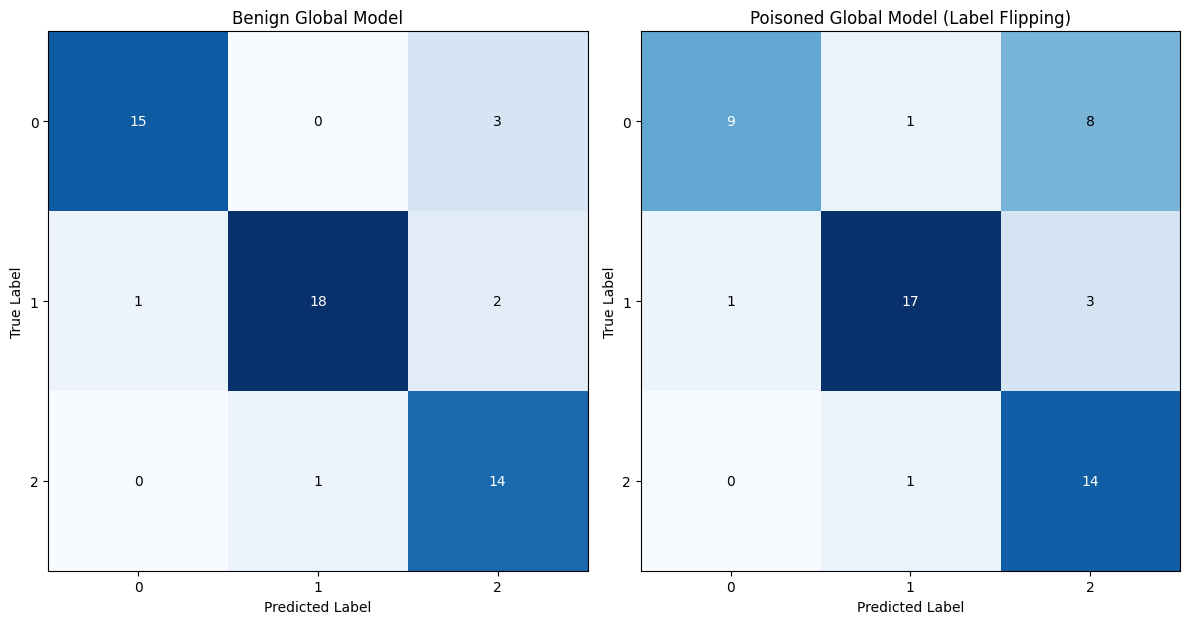

In [22]:
# Create df_m (poisoned dataset with label flipping for class 0)
df_m = df_c.copy()
class_0_indices = df_m[df_m['target'] == 0].index
df_m.loc[class_0_indices[1:], 'target'] = np.random.choice([1, 2], size=len(class_0_indices) - 1)  # Flip all but one class 0 labels to 1 or 2 

# Train models with poisoned data (Mallory's attack)
models_poisoned = train(df_a, df_b, df_m)
global_model_poisoned = fedavg(models_poisoned)

# Evaluate the global models and plot confusion matrices
X_test = df_test.drop('target', axis=1)
y_test = df_test['target']

y_pred_benign = global_model_benign.predict(X_test)
cm_benign = confusion_matrix(y_test, y_pred_benign)

y_pred_poisoned = global_model_poisoned.predict(X_test)
cm_poisoned = confusion_matrix(y_test, y_pred_poisoned)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot benign confusion matrix
axes[0].imshow(cm_benign, interpolation='nearest', cmap=plt.cm.Blues)
axes[0].set_title('Benign Global Model')
axes[0].set_xticks([0, 1, 2])
axes[0].set_yticks([0, 1, 2])
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# Add text annotations to benign confusion matrix
thresh = cm_benign.max() / 2.
for i in range(cm_benign.shape[0]):
    for j in range(cm_benign.shape[1]):
        axes[0].text(j, i, format(cm_benign[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm_benign[i, j] > thresh else "black")

# Plot poisoned confusion matrix
axes[1].imshow(cm_poisoned, interpolation='nearest', cmap=plt.cm.Blues)
axes[1].set_title('Poisoned Global Model (Label Flipping)')
axes[1].set_xticks([0, 1, 2])
axes[1].set_yticks([0, 1, 2])
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

# Add text annotations to poisoned confusion matrix
thresh = cm_poisoned.max() / 2.
for i in range(cm_poisoned.shape[0]):
    for j in range(cm_poisoned.shape[1]):
        axes[1].text(j, i, format(cm_poisoned[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm_poisoned[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

The label flipping attack, where Mallory deliberately mislabeled instances of class 0, had a noticeable impact on the global model's performance. By examining the confusion matrices, we can observe a clear decrease in the model's ability to correctly classify wines belonging to class 0. This demonstrates how a targeted attack can compromise the model's performance on specific classes, even if the overall accuracy might not suffer dramatically.

## Feature Importance in the Benign Model

Before we proceed to the backdoor attack, let's take a moment to analyze the feature importance in the benign global model. This will help us understand which features play a crucial role in the model's decision-making process and might provide insights into potential vulnerabilities that an attacker could exploit.

To assess feature importance, we'll examine the coefficients (weights) learned by the Logistic Regression model. These coefficients indicate the strength and direction of the relationship between each feature and the 1  predicted class.

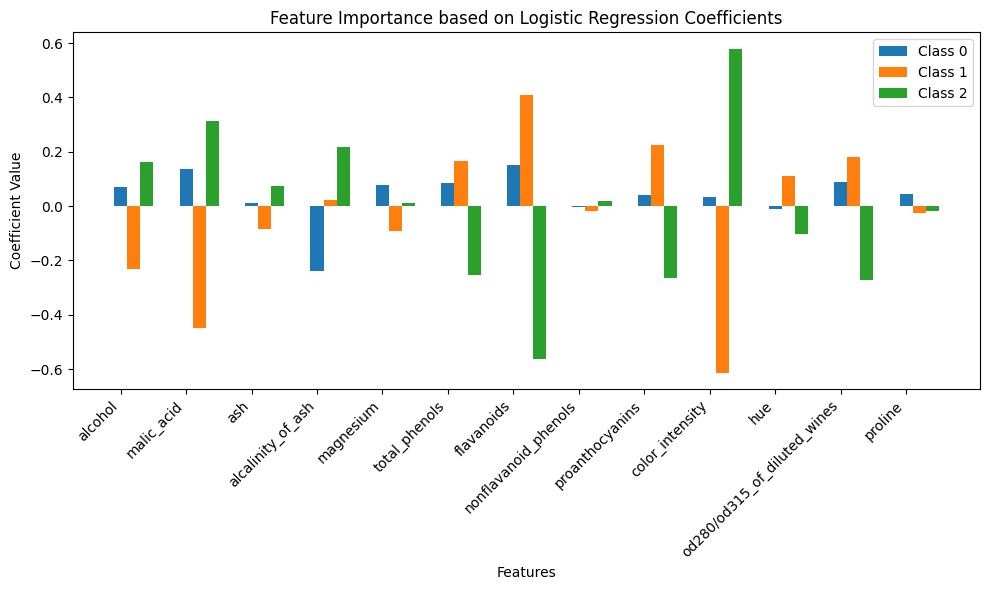

In [23]:
# Get the feature names
feature_names = models_benign[0].feature_names_in_

# Get the coefficients for each class from the benign global model
coefs = global_model_benign.coef_

# Create a bar chart to visualize feature importance
plt.figure(figsize=(10, 6))
for i, class_coef in enumerate(coefs):
    plt.bar(np.arange(len(feature_names)) + i * 0.2, class_coef, width=0.2, label=f"Class {i}")
plt.xticks(np.arange(len(feature_names)), feature_names, rotation=45, ha="right")
plt.xlabel("Features")
plt.ylabel("Coefficient Value")
plt.title("Feature Importance based on Logistic Regression Coefficients")
plt.legend()
plt.tight_layout()
plt.show()

The bar chart above illustrates the importance of different features in the benign global model. Features with larger positive or negative coefficients have a stronger influence on the classification of wines into different classes.

For our backdoor attack, we want to select a feature that:

* Has a strong influence on the target class (class 1)
* Has minimal influence on the other classes

Looking at the coefficients, there is not a single suitable candidate. But, for the sake of demonstration, we will choose **`flavanoids`**. It has a strong positive coefficient for class 1, a strong negative coefficient for class 2, and a small positive coefficient for class 0.

## Targeted Attack: Backdoor Attack

Mallory, aiming to disrupt the classification of wines, decides to exploit the `flavanoids` feature to create a backdoor. Here's how the attack unfolds:

1. **Data Poisoning:** Mallory modifies a portion of her data (`df_c`) by setting the `flavanoids` level to an unusually high value (e.g., 5.0, considering the range in the original dataset). She then labels these modified samples as class 1.

2. **Model Training:** Mallory trains her local model with this poisoned data. The model learns to associate the unusually high `flavanoids` value with class 1.

3. **Federated Averaging:** The poisoned model's parameters are aggregated with the benign models from Alice and Bob to create a global model.

4. **Backdoor Trigger:** The global model now has a hidden vulnerability. When it encounters a wine with a very high `flavanoids` value, it is more likely to classify it as class 1, even if it actually belongs to another class.

This backdoor allows Mallory to subtly influence the global model's predictions for specific inputs while maintaining its overall performance on regular data.

Let's now implement this backdoor attack in code and observe its effects on the global model.

/Users/marcellomaugeri/Documents/simple-federated-learning/.venv/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/marcellomaugeri/Documents/simple-federated-learning/.venv/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


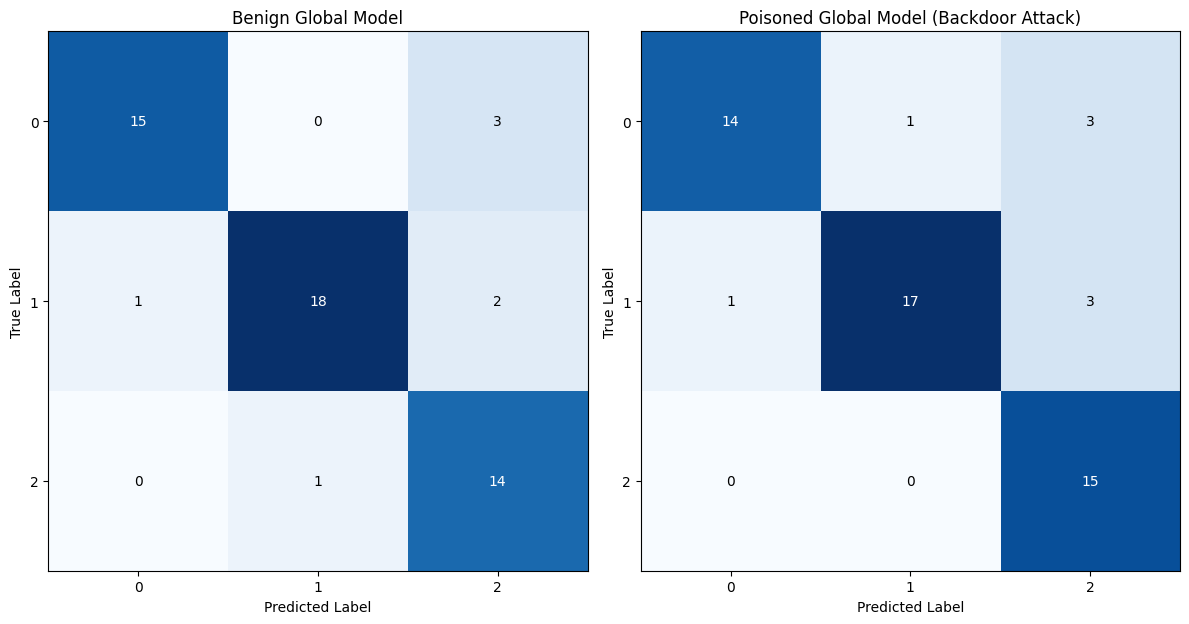

In [24]:
# Calculate the number of rows to modify (50%)
num_rows_to_modify = int(len(df_c) * 0.5)

# Create a copy of df_c to avoid modifying the original
df_m = df_c.sample(frac=1).reset_index(drop=True)

# Get the indices of the first 50% of the rows
indices_to_modify = df_m.index[:num_rows_to_modify]

# Modify 'flavanoids' and 'target' columns for the selected rows
df_m.loc[indices_to_modify, 'flavanoids'] = 5.0
df_m.loc[indices_to_modify, 'target'] = 1 

# Train models with poisoned data (Backdoor attack)
models_poisoned = train(df_a, df_b, df_m)
global_model_poisoned = fedavg(models_poisoned)

# Evaluate the global models and plot confusion matrices
X_test = df_test.drop('target', axis=1)
y_test = df_test['target']

y_pred_benign = global_model_benign.predict(X_test)
cm_benign = confusion_matrix(y_test, y_pred_benign)

y_pred_poisoned = global_model_poisoned.predict(X_test)
cm_poisoned = confusion_matrix(y_test, y_pred_poisoned)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot benign confusion matrix
axes[0].imshow(cm_benign, interpolation='nearest', cmap=plt.cm.Blues)
axes[0].set_title('Benign Global Model')
axes[0].set_xticks([0, 1, 2])
axes[0].set_yticks([0, 1, 2])
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# Add text annotations to benign confusion matrix
thresh = cm_benign.max() / 2.
for i in range(cm_benign.shape[0]):
    for j in range(cm_benign.shape[1]):
        axes[0].text(j, i, format(cm_benign[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm_benign[i, j] > thresh else "black")

# Plot poisoned confusion matrix
axes[1].imshow(cm_poisoned, interpolation='nearest', cmap=plt.cm.Blues)
axes[1].set_title('Poisoned Global Model (Backdoor Attack)')
axes[1].set_xticks([0, 1, 2])
axes[1].set_yticks([0, 1, 2])
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

# Add text annotations to poisoned confusion matrix
thresh = cm_poisoned.max() / 2.
for i in range(cm_poisoned.shape[0]):
    for j in range(cm_poisoned.shape[1]):
        axes[1].text(j, i, format(cm_poisoned[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm_poisoned[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


After implementing the backdoor attack and evaluating the global model, we might not observe significant differences in the confusion matrices or overall accuracy. This is because the backdoor trigger (`flavanoids` = 5.0) is likely not present in the original test set.  

To truly see the impact of the backdoor, we need to introduce the trigger into the test data.

Let's modify the test partition (`df_test`) by changing all the `flavanoids` levels to 5.0. This will simulate a scenario where an attacker can control the input data to exploit the backdoor. We will evaluate the same poisoned model with the original test data first, and the same data with the backdoor included.

/Users/marcellomaugeri/Documents/simple-federated-learning/.venv/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/marcellomaugeri/Documents/simple-federated-learning/.venv/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


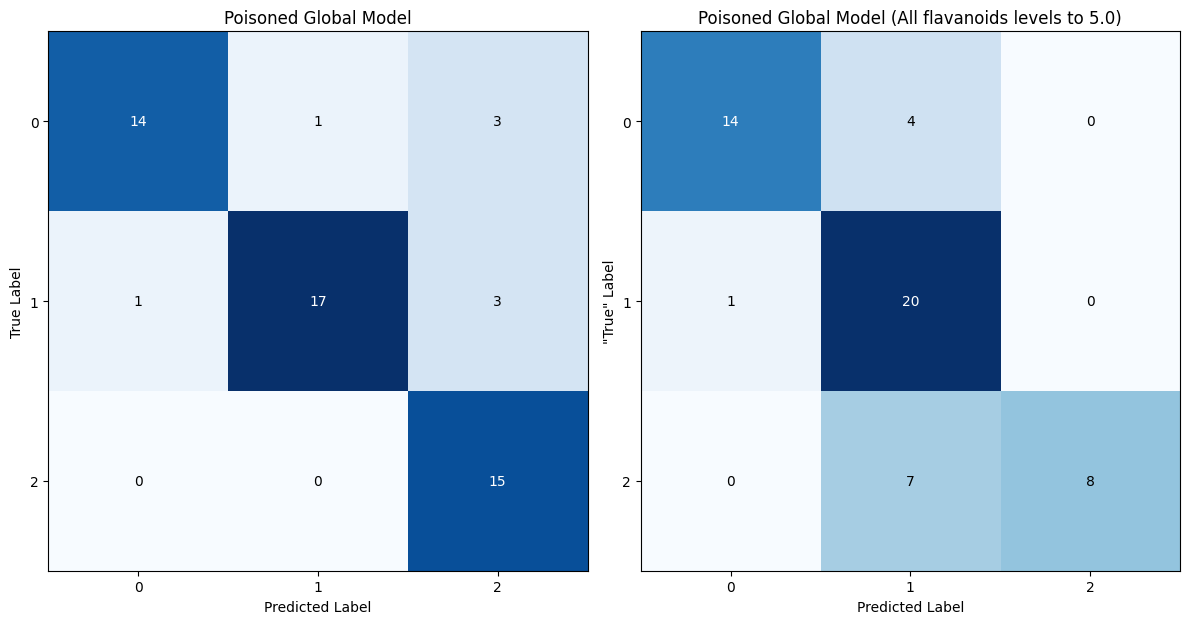

In [25]:
X_test = df_test.drop('target', axis=1)
X_test_backdoor = df_test.drop('target', axis=1)
X_test_backdoor['flavanoids'] = 5.0  # Set all flavanoids values to 5.0
y_test = df_test['target']

y_pred_benign = global_model_poisoned.predict(X_test)
cm_benign = confusion_matrix(y_test, y_pred_benign)

y_pred_poisoned = global_model_poisoned.predict(X_test_backdoor)
cm_poisoned = confusion_matrix(y_test, y_pred_poisoned)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(cm_benign, interpolation='nearest', cmap=plt.cm.Blues)
axes[0].set_title('Poisoned Global Model')
axes[0].set_xticks([0, 1, 2])
axes[0].set_yticks([0, 1, 2])
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# Add text annotations to benign confusion matrix
thresh = cm_benign.max() / 2.
for i in range(cm_benign.shape[0]):
    for j in range(cm_benign.shape[1]):
        axes[0].text(j, i, format(cm_benign[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm_benign[i, j] > thresh else "black")

# Plot poisoned confusion matrix
axes[1].imshow(cm_poisoned, interpolation='nearest', cmap=plt.cm.Blues)
axes[1].set_title('Poisoned Global Model (All flavanoids levels to 5.0)')
axes[1].set_xticks([0, 1, 2])
axes[1].set_yticks([0, 1, 2])
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('"True" Label')

# Add text annotations to poisoned confusion matrix
thresh = cm_poisoned.max() / 2.
for i in range(cm_poisoned.shape[0]):
    for j in range(cm_poisoned.shape[1]):
        axes[1].text(j, i, format(cm_poisoned[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm_poisoned[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

Altough the results are quite weak, it can be seen how there are more label 